# Plant growth

In [41]:
from __future__ import print_function
import openturns as ot
import otagrum
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

In [42]:
# Create variables
light = gum.LabelizedVariable("Light", "quality of light", 0)
moisture = gum.LabelizedVariable("Moisture", "quantity of moisture", 0)
height = gum.DiscretizedVariable("Height", "plant growth")

In [43]:
## Create labels and ticks

# light has 2 attributes : Dim and Bright
light.addLabel("Dim")
light.addLabel("Bright")
lightSize = len(light.labels())

# moisture has 2 attributes : Dry and Wet
moisture.addLabel("Dry")
moisture.addLabel("Wet")
moistureSize = len(moisture.labels())

# height is a discretized variable
data = range(0, 180, 10)
for i in data:
    height.addTick(i)

In [44]:
# height has a conditional probability table
# We give here its conditional distributions

# distribution when Dim and Dry
heightWhenDimAndDry = ot.Uniform(0.0, 20.0)
# distribution when Dim and Wet
heightWhenDimAndWet = ot.Triangular(15.0, 30.0, 50.0)
# distribution when Bright and Dry
heightWhenBrightAndDry = ot.Triangular(0.0, 15.0, 30.0)
# distribution when Bright and Wet
heightWhenBrightAndWet = ot.Normal(90.0, 10.0)


In [45]:
## Create the net
bn = gum.BayesNet("Plant Growth")

# Add variables
indexLight    = bn.add(light)
indexMoisture = bn.add(moisture)
indexHeight   = bn.add(height)

# Add arcs
bn.addArc(indexLight, indexMoisture)
bn.addArc(indexLight, indexHeight)
bn.addArc(indexMoisture, indexHeight)
bn

(gum::BayesNet<double>@0x2350690) BN{nodes: 3, arcs: 3, domainSize: 68, parameters: 74, compression ratio: -8% }

In [46]:
# Create conditional probability tables
# light conditional probability table
bn.cpt(indexLight)[:] = [0.25, 0.75]

# moisture conditional probability table
# We show the antecedents of moisture with the order in which they were declared
print("moisture Antecedents= ", bn.cpt(indexMoisture).var_names)
bn.cpt(indexMoisture)[{'Light' : 'Dim'}] = [0.2, 0.8]
bn.cpt(indexMoisture)[{'Light' : 'Bright'}] = [0.6, 0.4]

# We have to enter some OT distributions whithin aGrUM conditional probability tables
# We show the antecedents of height with the order in which they were declared
# The new class Utils from otagrum is able to marry OT distributions and Agrum conditional probability tables
bn.cpt(indexHeight)[{'Light': 'Dim', 'Moisture': 'Dry'}]   = otagrum.Utils.Discretize(heightWhenDimAndDry, height).tolist()
bn.cpt(indexHeight)[{'Light': 'Bright', 'Moisture': 'Dry'}] = otagrum.Utils.Discretize(heightWhenBrightAndDry, height).tolist()
bn.cpt(indexHeight)[{'Light': 'Dim', 'Moisture': 'Wet'}]    = otagrum.Utils.Discretize(heightWhenDimAndWet, height).tolist()
bn.cpt(indexHeight)[{'Light': 'Bright', 'Moisture': 'Wet'}] = otagrum.Utils.Discretize(heightWhenBrightAndWet, height).tolist()


moisture Antecedents=  ['Light', 'Moisture']


vnames ['Moisture', 'Light', 'Height']
desc [Height,Light,Moisture]


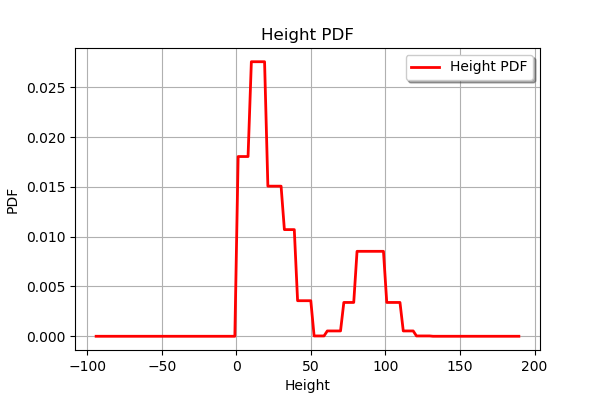

In [47]:
# Get the distribution of the variable "Height"
hpo = bn.cpt(indexHeight)
print('vnames', hpo.var_names)
#pos = h_po.pos(height)
pos = 0
hpo_distribution = otagrum.Utils.FromPotential(hpo)
print('desc', hpo_distribution.getDescription())
heightDistribution = hpo_distribution.getMarginal(pos)
heightDistribution.drawPDF()